# Missão 5 - SVM - Comparar diferentes configurações de SVM.

Utilizando o conjunto de dados Glass (https://archive.ics.uci.edu/ml/datasets/glass+identification).

Grupo: Hérikles Cordeiro e Juliana Loureiro

- Apresentar um relatório curto sobre os desempenhos médios (no treinamento, validação e teste), discussões e conclusões obtidas.

## **Introdução Support Vector Machine (SVM)**

### SVM com margens rígidas [3]
As SVMs lineares com margens rígidas definem fronteiras lineares a partir de dados linearmente separáveis.  Seja T um conjunto de treinamento com n dados $x_{i}\in X$ e seus respectivos rótulos $y_{i}\in Y$, em que $X$ constitui o espaço dos dados e $Y = \{-1;+1\}$. $T$ é linearmente separável se é possível separar os dados das classes $+1$ e $-1$ por um hiperplano.

A equação de um hiperplano é representada por $$f(x)=w·x+b=0,$$
onde $w·x$ é o produto escalar entre os vetores $w$ e $x$, $w\in X$ é o vetor normal ao hiperplano descrito e $\frac{b}{\|w\|}$ corresponde à distância do hiperplano em relação à origem, com $b \in \Re$. 

Essa equação dividi o espaço dos dados $X$ em duas regiões $w·x+b>0$ e $w·x+b<0$. Assim uma função sinal $g(x) = sgn(f(x))$ pode ser utilizada na obtenção das classificações, cujo valor $+1$ é obtido se $w·x+b>0$, $-1$ se $w·x+b<0$.

### SVM com margens suaves [3]
Em situações reais, é difícil encontrar aplicações cujos dados sejam linearmente separáveis. Isso se deve a diversos fatores, entre eles a presença de ruídos e outliers nos dados ou à própria natureza do problema, que pode ser não linear. Neste cenário o problema de SVM linear é extendido para lidar com esse problema.

Para realizar essa tarefa, permite-se que alguns dados possam violar a restrição de que não pode haver dados de treinamento entre as margens de separação das classes. Para isso são introduzidas variáveis de folga $\xi$, para todo $i = 1,...,n$. Essas variáveis relaxam as restrições impostas ao problema de otimização.
$$
y_{i}(w·x_{i}+b)\geq 1−\xi_{i}, \xi_{i}>0,\forall i = 1,...,n
$$

A aplicação desse procedimento suaviza as margens do classificador linear, permitindo que alguns dados permaneçam entre os hiperplanos e também a ocorrência de alguns erros de classificação. Por esse motivo, as SVMs obtidas neste caso também podem  ser referenciadas como SVMs com margens suaves.

Um erro no conjunto de treinamento é indicado por um valor de $\xi_{i}$ maior que 1. Logo,a soma dos $\xi_{i}$ representa um limite no número de erros de treinamento. Para levar em consideração esse termo, a função objetivo é reformulada, incluindo um termo constante $C$, termo de regularização, que impõe um peso à minimização dos erros no conjunto de treinamento em relação a minimização da complexidade do modelo. A presença do termo $\sum_{i=1}^{n} \xi_{i}$ no problema de otimização também pode ser vista como uma minimização de erros marginais, pois um valor de $\xi_{i} \in (0,1]$ indica um dado entre as margens. 

In [196]:
"""
Importação das bibliotecas usadas no Notebook
"""
import numpy as np
import pandas as pd
import sklearn.preprocessing as pre
import matplotlib.pyplot as plt
import seaborn as sn


from sklearn.utils.multiclass import class_distribution, unique_labels

#Pré-pocessamento
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import normalize

#Métricas
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

#Validação crizada
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold

#Modelos de Classificação
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression

## Explorando os dados

O conjunto de dados 'Glass' é contituído de 214 exemplos com 9 variáveis numéricas (continuas) e a variável alvo 'Type_of_glass' contém as respectivas classes (1 2 3 5 6 7).

Através da análise descritiva dos dados, pode-se verificar que as variáveis explicativas possuem diferentes escalas e isso pode ser um problema para modelos de SVM. Um outro aspecto identificado na tarefa de exploração é que existe correlação entre 2 das variáveis explicativas `RI` e `Ca`.

In [197]:
"""
Carregando os dados
"""
id_col = ['RI', 'Na', 'Mg', 'Al', 'Si','K', 'Ca', 'Ba', 'Fe', 'Type_of_glass']
df = pd.read_csv('base/glass.csv',  encoding='UTF-8',sep=',', names=id_col, index_col=0)

#print dados
print(df)

          RI     Na    Mg    Al     Si     K    Ca    Ba   Fe  Type_of_glass
1    1.52101  13.64  4.49  1.10  71.78  0.06  8.75  0.00  0.0              1
2    1.51761  13.89  3.60  1.36  72.73  0.48  7.83  0.00  0.0              1
3    1.51618  13.53  3.55  1.54  72.99  0.39  7.78  0.00  0.0              1
4    1.51766  13.21  3.69  1.29  72.61  0.57  8.22  0.00  0.0              1
5    1.51742  13.27  3.62  1.24  73.08  0.55  8.07  0.00  0.0              1
..       ...    ...   ...   ...    ...   ...   ...   ...  ...            ...
210  1.51623  14.14  0.00  2.88  72.61  0.08  9.18  1.06  0.0              7
211  1.51685  14.92  0.00  1.99  73.06  0.00  8.40  1.59  0.0              7
212  1.52065  14.36  0.00  2.02  73.42  0.00  8.44  1.64  0.0              7
213  1.51651  14.38  0.00  1.94  73.61  0.00  8.48  1.57  0.0              7
214  1.51711  14.23  0.00  2.08  73.36  0.00  8.62  1.67  0.0              7

[214 rows x 10 columns]


In [198]:
"""
Separanda as classes
"""
r_classes = unique_labels(df['Type_of_glass'])
print('Rotulos da classe: ',r_classes)

Rotulos da classe:  [1 2 3 5 6 7]


In [199]:
print('Alguns dados estatisticos')
print(df.describe())

Alguns dados estatisticos
               RI          Na          Mg          Al          Si           K  \
count  214.000000  214.000000  214.000000  214.000000  214.000000  214.000000   
mean     1.518365   13.407850    2.684533    1.444907   72.650935    0.497056   
std      0.003037    0.816604    1.442408    0.499270    0.774546    0.652192   
min      1.511150   10.730000    0.000000    0.290000   69.810000    0.000000   
25%      1.516523   12.907500    2.115000    1.190000   72.280000    0.122500   
50%      1.517680   13.300000    3.480000    1.360000   72.790000    0.555000   
75%      1.519157   13.825000    3.600000    1.630000   73.087500    0.610000   
max      1.533930   17.380000    4.490000    3.500000   75.410000    6.210000   

               Ca          Ba          Fe  Type_of_glass  
count  214.000000  214.000000  214.000000     214.000000  
mean     8.956963    0.175047    0.057009       2.780374  
std      1.423153    0.497219    0.097439       2.103739  
min     

In [200]:
#Calcula a correlação entra as variáveis independentes. 
#print('A matrix de correlacao\n',df.corr())
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm')


,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type_of_glass
RI,1.000000,-0.191885,-0.122274,-0.407326,-0.542052,-0.289833,0.810403,-0.000386,0.143010,-0.164237
Na,-0.191885,1.000000,-0.273732,0.156794,-0.069809,-0.266087,-0.275442,0.326603,-0.241346,0.502898
Mg,-0.122274,-0.273732,1.000000,-0.481799,-0.165927,0.005396,-0.443750,-0.492262,0.083060,-0.744993
Al,-0.407326,0.156794,-0.481799,1.000000,-0.005524,0.325958,-0.259592,0.479404,-0.074402,0.598829
Si,-0.542052,-0.069809,-0.165927,-0.005524,1.000000,-0.193331,-0.208732,-0.102151,-0.094201,0.151565
K,-0.289833,-0.266087,0.005396,0.325958,-0.193331,1.000000,-0.317836,-0.042618,-0.007719,-0.010054
Ca,0.810403,-0.275442,-0.443750,-0.259592,-0.208732,-0.317836,1.000000,-0.112841,0.124968,0.000952
Ba,-0.000386,0.326603,-0.492262,0.479404,-0.102151,-0.042618,-0.112841,1.000000,-0.058692,0.575161
Fe,0.143010,-0.241346,0.083060,-0.074402,-0.094201,-0.007719,0.124968,-0.058692,1.000000,-0.188278
Type_of_glass,-0.164237,0.502898,-0.744993,0.598829,0.151565,-0.010054,0.000952,0.575161,-0.188278,1.000000


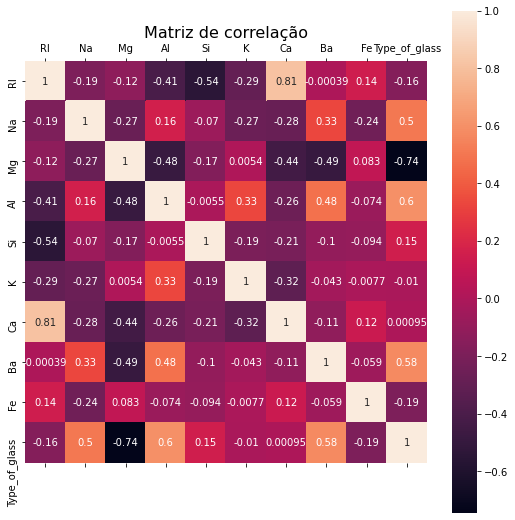

In [201]:
plt.rcParams["figure.figsize"] = (9,9)
plt.matshow(df.corr())
sn.heatmap(df.corr(), annot=True)
plt.title('Matriz de correlação', fontsize=16);
plt.show()

In [202]:
"""
Separadando as feature das classes da base de dados
"""
#feature
X = df.iloc[:, 0:9].values
#classes
y = df.iloc[:, -1].values

#separação da base em Treinamento × Teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=415)

## Avaliação diferentes classificadores, sem realizar pre-processamento dos dados
O intuito deste estudo é apresentar o desempenho do classificador SVM executando diferentes configurações dos parâmetros. Para realizar essa tarefa, foi usado o pacote do [Scikit-learn](https://scikit-learn.org/stable/index.html "Home do scikit-learn").

Inicialmente foram implementados os classificadores:  
 - Support vector machine for classification
 - K Nearest Neighbors
 - Gaussian Naive Bayes
 - Regressão logística

sem nenhuma parametrização e sem realizar o pre-processamento dos dados. Em seguida, analisaremos o ganho para o SVM na tarefa de classificação quando é realizado o pre-processamento dos dados e a parametrização do modelo. 

Os resultados dos modelos simples não são satisfatórios para a tarefa de classificação dos dados. Pois, apresentam baixa acurácia, indicando que o modelo não é capaz de classificar corretamente os dados. Salvo o $K$-NN, que obteve uma classificação satisfatória, pois não depende da escala das variáveis de entrada.

Os modelos `SVC`, `Gaussian NB` e `Regressão logística` não foram capazes de classificar os dados, e gerou a mesma classe para todas as observações. 

No caso do `SVC`, nosso foco neste estudo, isto ocorreu porque o processo de otimização deste método, ocorre através da minimização do vetor de decisão w. O hiperplano ótimo é influenciado pela escala das variáveis de entrada e portanto é recomendado padronizar as variáveis, deixando-as com média 0 e variância 1.

"
It’s not difficult to see that the non-standardized data produces decision hyperplanes that are highly sensitive to coefficient C"


In [203]:
#Classificadores com os paremetros no patrao (arrumar outro nome)
clf = svm.SVC()
knn = KNeighborsClassifier()
gnb = GaussianNB()
reg = LogisticRegression()

#Colocar um nome
clf.fit(X_train, y_train)
knn.fit(X_train, y_train)
gnb.fit(X_train, y_train)
reg.fit(X_train, y_train)
print('Classificadores treinados')

Classificadores treinados


#### Desempenho dos modelos sem pré-processamento ou ajuste de parâmetros 

In [204]:
#Colocar um nome aqui
y_svm = clf.predict(X_test)
y_knn = knn.predict(X_test)
y_gnb = gnb.predict(X_test)
y_reg = reg.predict(X_test)

#Acuracias dos modelos sem pre-processamento
print('K-NN: ', accuracy_score(y_test, y_knn))
print('Gaussian NB: ', accuracy_score(y_test, y_gnb))
print('Regresao logistica (lr): ', accuracy_score(y_test, y_reg))
print('SVM: ', accuracy_score(y_test, y_svm))

K-NN:  0.7441860465116279
Gaussian NB:  0.4883720930232558
Regresao logistica (lr):  0.6511627906976745
SVM:  0.3023255813953488


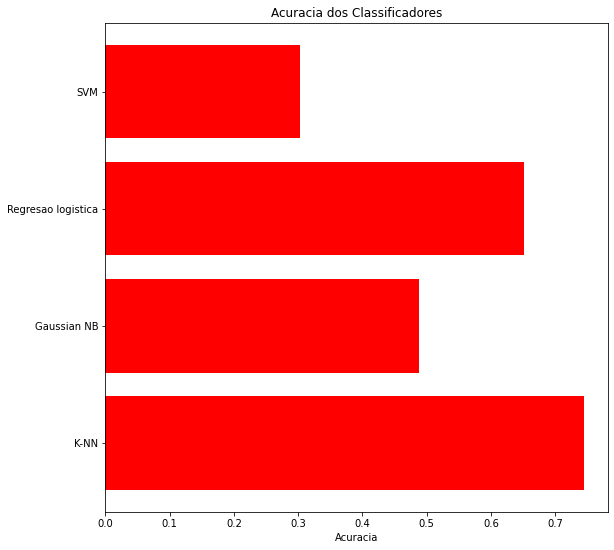

In [205]:
## Grafico de acuracia
nome_classificadores = ['K-NN', 'Gaussian NB', 'Regresao logistica','SVM']
metricas = [accuracy_score(y_test, y_knn), accuracy_score(y_test, y_gnb), accuracy_score(y_test, y_reg), accuracy_score(y_test, y_svm)]
plt.barh(nome_classificadores, metricas, color='red')
plt.xlabel('Acuracia')
plt.title('Acuracia dos Classificadores')
plt.show()

## Pré-processamento de dados

Descrever o processo
1. segundo a base de dados, não tem Missing Values(dados ausentes)
1. Não existe dados categoricos, alem das classes
1. Normalização (MinMax, normalização pela magnitude)
1. Padronização (média e desvio padrão).


In [206]:
#Dados normalizados
X_min_max = MinMaxScaler().fit_transform(X.copy())
X_min_max = pd.DataFrame(X_min_max, columns=id_col[0:9])

#separação da base min_max em Treinamento × Teste 
X_min_max_train, X_min_max_test, y_min_max_train, y_min_max_test = train_test_split(X_min_max, y, test_size=0.33, random_state=4135)

print('Dados normalizados (Min_max) \n',X_min_max)

Dados normalizados (Min_max) 
            RI        Na        Mg        Al        Si         K        Ca  \
0    0.432836  0.437594  1.000000  0.252336  0.351786  0.009662  0.308550   
1    0.283582  0.475188  0.801782  0.333333  0.521429  0.077295  0.223048   
2    0.220808  0.421053  0.790646  0.389408  0.567857  0.062802  0.218401   
3    0.285777  0.372932  0.821826  0.311526  0.500000  0.091787  0.259294   
4    0.275241  0.381955  0.806236  0.295950  0.583929  0.088567  0.245353   
..        ...       ...       ...       ...       ...       ...       ...   
209  0.223003  0.512782  0.000000  0.806854  0.500000  0.012882  0.348513   
210  0.250219  0.630075  0.000000  0.529595  0.580357  0.000000  0.276022   
211  0.417032  0.545865  0.000000  0.538941  0.644643  0.000000  0.279740   
212  0.235294  0.548872  0.000000  0.514019  0.678571  0.000000  0.283457   
213  0.261633  0.526316  0.000000  0.557632  0.633929  0.000000  0.296468   

           Ba   Fe  
0    0.000000  0.0  
1 

In [207]:
#
X_norm = normalize(X.copy(), norm='l2')
X_norm = pd.DataFrame(X_norm, columns=id_col[0:9])
#separação da base min_max em Treinamento × Teste 
X_norm_train, X_norm_test, y_norm_train, y_norm_test = train_test_split(X_norm, y, test_size=0.33, random_state=4215)

print('Dados normalizados (Normalization) \n',X_norm)

Dados normalizados (Normalization) 
            RI        Na        Mg        Al        Si         K        Ca  \
0    0.020625  0.184956  0.060884  0.014916  0.973323  0.000814  0.118648   
1    0.020350  0.186259  0.048274  0.018237  0.975277  0.006437  0.104997   
2    0.020282  0.180987  0.047487  0.020600  0.976368  0.005217  0.104071   
3    0.020404  0.177605  0.049611  0.017344  0.976220  0.007663  0.110515   
4    0.020279  0.177341  0.048378  0.016571  0.976647  0.007350  0.107848   
..        ...       ...       ...       ...       ...       ...       ...   
209  0.020319  0.189493  0.000000  0.038596  0.973063  0.001072  0.123023   
210  0.020198  0.198674  0.000000  0.026499  0.972861  0.000000  0.111854   
211  0.020182  0.190587  0.000000  0.026810  0.974438  0.000000  0.112017   
212  0.020077  0.190373  0.000000  0.025683  0.974505  0.000000  0.112265   
213  0.020151  0.189014  0.000000  0.027628  0.974424  0.000000  0.114498   

           Ba   Fe  
0    0.000000  0.

In [208]:
# 
X_stand = pre.StandardScaler().fit_transform(X.copy())
X_stand = pd.DataFrame(X_stand, columns=id_col[0:9])

#separação da base padronizada em Treinamento × Teste 
X_stand_train, X_stand_test, y_stand_train, y_stand_test = train_test_split(X_stand, y, test_size=0.33, random_state=4135)

print('Dados Padronizados \n', X_stand)

Dados Padronizados 
            RI        Na        Mg        Al        Si         K        Ca  \
0    0.872868  0.284953  1.254639 -0.692442 -1.127082 -0.671705 -0.145766   
1   -0.249333  0.591817  0.636168 -0.170460  0.102319 -0.026213 -0.793734   
2   -0.721318  0.149933  0.601422  0.190912  0.438787 -0.164533 -0.828949   
3   -0.232831 -0.242853  0.698710 -0.310994 -0.052974  0.112107 -0.519052   
4   -0.312045 -0.169205  0.650066 -0.411375  0.555256  0.081369 -0.624699   
..        ...       ...       ...       ...       ...       ...       ...   
209 -0.704815  0.898681 -1.865511  2.881125 -0.052974 -0.640968  0.157088   
210 -0.500178  1.856097 -1.865511  1.094342  0.529374 -0.763919 -0.392276   
211  0.754046  1.168721 -1.865511  1.154570  0.995252 -0.763919 -0.364103   
212 -0.612399  1.193270 -1.865511  0.993960  1.241133 -0.763919 -0.335931   
213 -0.414363  1.009152 -1.865511  1.275028  0.917606 -0.763919 -0.237327   

           Ba        Fe  
0   -0.352877 -0.586451  
1 

In [209]:
#Treinamento com base min_max
# Colocar um nome
clf.fit(X_min_max_train, y_min_max_train)
knn.fit(X_min_max_train, y_min_max_train)
reg.fit(X_min_max_train, y_min_max_train)
gnb.fit(X_min_max_train, y_min_max_train)
print('Classificadores treinados para os dados X_min_max')

Classificadores treinados para os dados X_min_max


In [210]:
#predicao com base min_max
#Colocar um nome aqui
y_min_max_svm = clf.predict(X_min_max_test)
y_min_max_knn = knn.predict(X_min_max_test)
y_min_max_reg = reg.predict(X_min_max_test)
y_min_max_gnb = gnb.predict(X_min_max_test)

#Acuracias dos modelos sem pre-processamento
print('k-NN\n', classification_report(y_min_max_test, y_min_max_knn))
print('Gaussian NB\n', classification_report(y_min_max_test, y_min_max_gnb))
print('Regrecao logistica\n', classification_report(y_min_max_test, y_min_max_reg))
print('SVC\n', classification_report(y_min_max_test, y_min_max_svm))

k-NN
               precision    recall  f1-score   support

           1       0.67      0.76      0.71        21
           2       0.58      0.78      0.67        23
           3       0.00      0.00      0.00         9
           5       0.67      0.25      0.36         8
           6       0.50      1.00      0.67         2
           7       0.67      0.75      0.71         8

    accuracy                           0.62        71
   macro avg       0.51      0.59      0.52        71
weighted avg       0.55      0.62      0.57        71

Gaussian NB
               precision    recall  f1-score   support

           1       0.75      0.14      0.24        21
           2       0.67      0.17      0.28        23
           3       0.20      0.89      0.32         9
           5       0.75      0.38      0.50         8
           6       0.50      1.00      0.67         2
           7       0.67      1.00      0.80         8

    accuracy                           0.39        71
   m

In [211]:
#Treinamento com base normalizada
# Colocar um nome
clf.fit(X_norm_train, y_norm_train)
knn.fit(X_norm_train, y_norm_train)
reg.fit(X_norm_train, y_norm_train)
gnb.fit(X_norm_train, y_norm_train)
print('Classificadores treinados para os dados X_norm')

Classificadores treinados para os dados X_norm


In [212]:
#predicao com base min_max
#Colocar um nome aqui
y_norm_svm = clf.predict(X_norm_test)
y_norm_knn = knn.predict(X_norm_test)
y_norm_reg = reg.predict(X_norm_test)
y_norm_gnb = gnb.predict(X_norm_test)

#Acuracias dos modelos sem pre-processamento
print('k-NN\n', classification_report(y_norm_test, y_norm_knn))
print('Gaussian NB\n', classification_report(y_norm_test, y_norm_gnb))
print('Regrecao logistica\n', classification_report(y_norm_test, y_norm_reg))
print('SVC\n', classification_report(y_norm_test, y_norm_svm))

k-NN
               precision    recall  f1-score   support

           1       0.63      0.79      0.70        24
           2       0.67      0.67      0.67        24
           3       0.00      0.00      0.00         4
           5       0.50      0.75      0.60         4
           6       0.00      0.00      0.00         5
           7       0.89      0.80      0.84        10

    accuracy                           0.65        71
   macro avg       0.45      0.50      0.47        71
weighted avg       0.59      0.65      0.62        71

Gaussian NB
               precision    recall  f1-score   support

           1       0.50      0.83      0.62        24
           2       0.25      0.04      0.07        24
           3       0.17      0.25      0.20         4
           5       0.22      0.50      0.31         4
           6       0.71      1.00      0.83         5
           7       1.00      0.50      0.67        10

    accuracy                           0.48        71
   m

In [213]:
#Treinamento com dados padronizados
clf.fit(X_stand_train, y_stand_train)
knn.fit(X_stand_train, y_stand_train)
reg.fit(X_stand_train, y_stand_train)
gnb.fit(X_stand_train, y_stand_train)
print('Classificadores treinados para os dados X_stand')

Classificadores treinados para os dados X_stand


In [214]:
#predicao com dados padronizados
y_stand_svm = clf.predict(X_stand_test)
y_stand_knn = knn.predict(X_stand_test)
y_stand_reg = reg.predict(X_stand_test)
y_stand_gnb = gnb.predict(X_stand_test)

#Acuracias dos modelos para os dados padronizados
print('k-NN\n', classification_report(y_stand_test, y_stand_knn))
print('Gaussian NB\n', classification_report(y_stand_test, y_stand_gnb))
print('regressao logistica\n', classification_report(y_stand_test, y_stand_reg))
print('SVC\n', classification_report(y_stand_test, y_stand_svm))

k-NN
               precision    recall  f1-score   support

           1       0.59      0.76      0.67        21
           2       0.56      0.65      0.60        23
           3       0.00      0.00      0.00         9
           5       0.50      0.25      0.33         8
           6       0.67      1.00      0.80         2
           7       0.70      0.88      0.78         8

    accuracy                           0.59        71
   macro avg       0.50      0.59      0.53        71
weighted avg       0.51      0.59      0.54        71

Gaussian NB
               precision    recall  f1-score   support

           1       0.67      0.10      0.17        21
           2       0.67      0.17      0.28        23
           3       0.19      0.89      0.31         9
           5       0.75      0.38      0.50         8
           6       0.50      1.00      0.67         2
           7       0.67      1.00      0.80         8

    accuracy                           0.38        71
   m

In [215]:
#K-fold
n_splits=5
n_repeats=10
rkf = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=2652124)

In [216]:
def K_fold(clf,X_, y_, axis_=None, metrica='accuracy'):
    ind_k_fold = rkf.split(X_)
    temp = []
    for train_index, test_index in ind_k_fold:
        X_train, X_test = X_[train_index], X_[test_index]
        y_train, y_test = y_[train_index], y_[test_index]

        clf.fit(X_train,y_train)
        y_np = clf.predict(X_test)
        scores_svm = classification_report(y_test,y_np,output_dict=True) 
        temp.append(scores_svm[metrica])
    return np.array(temp).reshape(n_splits,n_repeats).mean(axis=axis_)

def valida_paremetros(C:list, X_,y_,metrica='accuracy',kernel_='rbf', degree_=3, axis_=None):
    resp = []
    if len(C)>1:
        for x in C:
            clf = svm.SVC(C=x,kernel=kernel_,degree=degree_)
            resp.append([x, K_fold(clf,X_,y_,axis_,metrica)])
        return np.array(resp)
    elif len(degree_)>1 and kernel_=='poly':
        for x in degree_:
            clf = svm.SVC(C=C[0],kernel=kernel_,degree=x)
            resp.append([x, K_fold(clf,X_,y_,axis_,metrica)])
        return np.array(resp)
    else:
        clf = svm.SVC(C=C,kernel=kernel_,degree=x)
        return [x, K_fold(clf,X_,y_,axis_,metrica)]

In [217]:
# Para esse trabalho parte vamos usar as base de treimento(onde seré dividido no k-fold) e test
C = [2, 3, 5, 7, 11, 13, 17, 19, 23, 29, 31, 37, 41, 43, 47, 53, 59, 61, 67, 71, 73, 79, 83, 89, 97, 101, 103, 107, 109, 113, 127, 131,137, 139, 149, 151, 157, 163, 167, 173, 179, 181, 191, 193, 197, 199]
#Treimando non-preprocessing
acuracias = pd.DataFrame(valida_paremetros(C,X_train,y_train,axis_=1), columns=['C', 'Acuracias'])
print(acuracias)

      C                                          Acuracias
0     2  [0.33613445378151263, 0.32731092436974796, 0.3...
1     3  [0.33613445378151263, 0.32731092436974796, 0.3...
2     5  [0.33613445378151263, 0.32731092436974796, 0.3...
3     7  [0.33613445378151263, 0.32731092436974796, 0.3...
4    11  [0.3420168067226891, 0.3302521008403362, 0.333...
5    13  [0.36260504201680677, 0.35084033613445376, 0.3...
6    17  [0.41512605042016804, 0.41495798319327737, 0.4...
7    19  [0.4178151260504202, 0.42075630252100843, 0.42...
8    23  [0.42932773109243694, 0.4264705882352942, 0.43...
9    29  [0.44084033613445384, 0.43235294117647066, 0.4...
10   31  [0.43226890756302516, 0.43235294117647066, 0.4...
11   37  [0.42369747899159665, 0.43235294117647055, 0.4...
12   41  [0.4207563025210083, 0.43235294117647055, 0.42...
13   43  [0.4207563025210083, 0.43235294117647066, 0.42...
14   47  [0.4207563025210083, 0.44109243697478995, 0.42...
15   53  [0.42369747899159665, 0.44983193277310923, 0.4.

In [218]:
acuracias_mm = pd.DataFrame(valida_paremetros(C,X_min_max_train.values,y_min_max_train,axis_=1), columns=['C', 'Acuracias'])
print(acuracias_mm)

      C                                          Acuracias
0     2  [0.6123152709359606, 0.6719211822660098, 0.682...
1     3  [0.6509852216748768, 0.679064039408867, 0.6891...
2     5  [0.6580049261083744, 0.7030788177339902, 0.682...
3     7  [0.668472906403941, 0.6822660098522167, 0.6929...
4    11  [0.6684729064039409, 0.6820197044334976, 0.692...
5    13  [0.6682266009852217, 0.6682266009852216, 0.685...
6    17  [0.6613300492610839, 0.6716748768472907, 0.678...
7    19  [0.6610837438423646, 0.6751231527093596, 0.682...
8    23  [0.6506157635467982, 0.6785714285714286, 0.692...
9    29  [0.6539408866995073, 0.6716748768472907, 0.689...
10   31  [0.6433497536945813, 0.675, 0.6858374384236453...
11   37  [0.6224137931034482, 0.6646551724137931, 0.682...
12   41  [0.6222906403940887, 0.6612068965517242, 0.682...
13   43  [0.6222906403940887, 0.6612068965517242, 0.692...
14   47  [0.6258620689655172, 0.6751231527093596, 0.689...
15   53  [0.6293103448275861, 0.6751231527093596, 0.685.

In [219]:
acuracias_norm = pd.DataFrame(valida_paremetros(C,X_norm_train.values,y_norm_train,axis_=1), columns=['C', 'Acuracias'])
print(acuracias_norm)

      C                                          Acuracias
0     2  [0.30825123152709366, 0.31477832512315274, 0.3...
1     3  [0.30825123152709366, 0.31477832512315274, 0.3...
2     5  [0.30825123152709366, 0.31477832512315274, 0.3...
3     7  [0.30825123152709366, 0.31477832512315274, 0.3...
4    11  [0.30098522167487685, 0.31822660098522165, 0.3...
5    13  [0.3185960591133005, 0.33546798029556646, 0.32...
6    17  [0.3571428571428571, 0.4023399014778325, 0.366...
7    19  [0.37783251231527093, 0.40258620689655167, 0.3...
8    23  [0.4054187192118227, 0.4232758620689655, 0.405...
9    29  [0.4088669950738916, 0.41637931034482756, 0.41...
10   31  [0.40197044334975374, 0.41637931034482756, 0.4...
11   37  [0.4054187192118227, 0.4235221674876847, 0.412...
12   41  [0.40197044334975374, 0.4233990147783251, 0.41...
13   43  [0.40197044334975374, 0.4233990147783251, 0.41...
14   47  [0.40197044334975374, 0.4304187192118226, 0.43...
15   53  [0.4055418719211823, 0.42684729064039406, 0.43.

In [220]:
acuracias_stand = pd.DataFrame(valida_paremetros(C,X_stand_train.values,y_stand_train,axis_=1), columns=['C', 'Acuracias'])
print(acuracias_stand)

      C                                          Acuracias
0     2  [0.6789408866995074, 0.6786945812807882, 0.706...
1     3  [0.6821428571428572, 0.685591133004926, 0.7102...
2     5  [0.6921182266009852, 0.6854679802955665, 0.713...
3     7  [0.6820197044334976, 0.6786945812807883, 0.699...
4    11  [0.6677339901477832, 0.6716748768472907, 0.675...
5    13  [0.6605911330049261, 0.6716748768472907, 0.668...
6    17  [0.6640394088669951, 0.6786945812807882, 0.668...
7    19  [0.6710591133004926, 0.6752463054187192, 0.668...
8    23  [0.6571428571428573, 0.6679802955665025, 0.668...
9    29  [0.656896551724138, 0.6572660098522166, 0.6720...
10   31  [0.663793103448276, 0.6607142857142857, 0.6756...
11   37  [0.6533251231527093, 0.6571428571428571, 0.679...
12   41  [0.6567733990147784, 0.6641625615763547, 0.682...
13   43  [0.6533251231527094, 0.6607142857142857, 0.682...
14   47  [0.6532019704433498, 0.6641625615763547, 0.682...
15   53  [0.6567733990147784, 0.6607142857142857, 0.679.

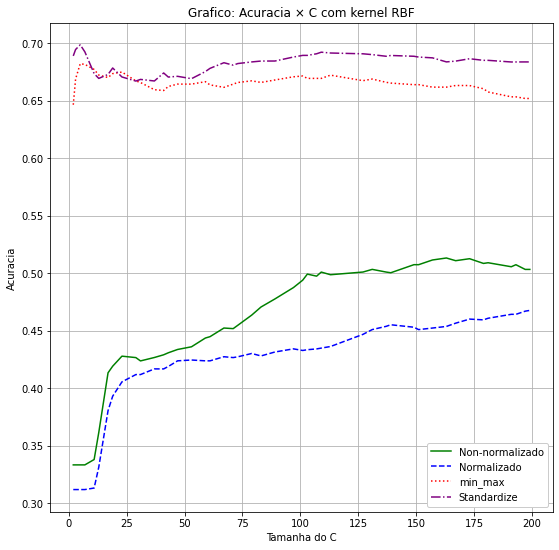

In [221]:
#Plot 
plt.plot(acuracias.iloc[:,0].values, [x.mean() for x in acuracias.iloc[:,1].to_numpy()], color='g', label='Non-normalizado')
plt.plot(acuracias_norm.iloc[:,0].values, [x.mean() for x in acuracias_norm.iloc[:,1].to_numpy()], color='b' , linestyle='--', label='Normalizado')
plt.plot(acuracias_mm.iloc[:,0].values, [x.mean() for x in acuracias_mm.iloc[:,1].to_numpy()], color='r',linestyle=':', label='min_max')

plt.plot(acuracias_stand.iloc[:,0].values, [x.mean() for x in acuracias_stand.iloc[:,1].to_numpy()], color='purple',linestyle='-.', label='Standardize')
plt.ylabel('Acuracia')
plt.xlabel('Tamanha do C')
plt.title('Grafico: Acuracia × C com kernel RBF')
plt.grid(True)
plt.legend(framealpha=1, frameon=True)
plt.show()

In [222]:
#Baseado nos resultado anteriores
C_max_non_norm = acuracias.iloc[np.argmax(np.array([x.mean() for x in acuracias.iloc[:,1].to_numpy()])),0]
C_max_min_max = acuracias_mm.iloc[np.argmax(np.array([x.mean() for x in acuracias_mm.iloc[:,1].to_numpy()])),0]
C_max_norm= acuracias_norm.iloc[np.argmax(np.array([x.mean() for x in acuracias_norm.iloc[:,1].to_numpy()])),0]
C_max_stand= acuracias_stand.iloc[np.argmax(np.array([x.mean() for x in acuracias_stand.iloc[:,1].to_numpy()])),0]

print('C:')
print('Non_normalizado: ',C_max_non_norm)
print('Normalizado: ',C_max_norm)
print('Min_max: ',C_max_min_max)
print('Standardize: ',C_max_stand)

C:
Non_normalizado:  163
Normalizado:  199
Min_max:  5
Standardize:  5


In [223]:
# Com base 101 não dá para usar grau maior que 71 rapidamente 
#d = [2, 3, 5, 7, 11, 13, 17, 19, 23, 29, 31, 37, 41, 43, 47, 53, 59, 61, 67]
d = [2, 3, 5, 7, 11, 13, 17, 19]
acuracias_poly = pd.DataFrame(valida_paremetros([C_max_non_norm],X_train,y,kernel_='poly', degree_=d, axis_=1), columns=['Grau', 'Acuracias'])
print(acuracias_poly)

  Grau                                          Acuracias
0    2  [0.38563025210084034, 0.41462184873949576, 0.4...
1    3  [0.38563025210084034, 0.39747899159663863, 0.4...
2    5  [0.38563025210084034, 0.3945378151260504, 0.40...
3    7  [0.37109243697478994, 0.397563025210084, 0.404...
4   11  [0.362436974789916, 0.4060504201680672, 0.4130...
5   13  [0.4030252100840336, 0.42042016806722693, 0.41...
6   17  [0.4472268907563025, 0.45294117647058824, 0.43...
7   19  [0.4411764705882352, 0.46731092436974786, 0.45...


In [224]:
acuracias_norm_poly = pd.DataFrame(valida_paremetros([C_max_norm],X_norm_train.values,y_norm_train,kernel_='poly', degree_=d, axis_=1), columns=['Grau', 'Acuracias'])
print(acuracias_norm_poly)

  Grau                                          Acuracias
0    2  [0.4921182266009853, 0.49334975369458134, 0.44...
1    3  [0.5032019704433497, 0.5389162561576354, 0.489...
2    5  [0.5561576354679802, 0.5768472906403941, 0.580...
3    7  [0.6084975369458128, 0.6152709359605912, 0.597...
4   11  [0.660960591133005, 0.6254926108374385, 0.6363...
5   13  [0.6541871921182266, 0.6254926108374386, 0.653...
6   17  [0.6538177339901479, 0.6147783251231527, 0.642...
7   19  [0.6503694581280789, 0.6147783251231527, 0.646...


In [225]:
acuracias_mm_poly = pd.DataFrame(valida_paremetros([C_max_min_max],X_min_max_train.values,y_min_max_train,kernel_='poly', degree_=d, axis_=1), columns=['Grau', 'Acuracias'])
print(acuracias_mm_poly)

  Grau                                          Acuracias
0    2  [0.6474137931034483, 0.6789408866995074, 0.664...
1    3  [0.6330049261083743, 0.6615763546798029, 0.674...
2    5  [0.6607142857142857, 0.6716748768472905, 0.688...
3    7  [0.6919950738916255, 0.7038177339901479, 0.699...
4   11  [0.6820197044334976, 0.6864532019704433, 0.688...
5   13  [0.6784482758620689, 0.6864532019704433, 0.685...
6   17  [0.6501231527093596, 0.6722906403940886, 0.653...
7   19  [0.65, 0.66871921182266, 0.6605911330049261, 0...


In [226]:
acuracias_stand_poly = pd.DataFrame(valida_paremetros([C_max_stand],X_stand_train.values,y_stand_train,kernel_='poly', degree_=d, axis_=1), columns=['Grau', 'Acuracias'])
print(acuracias_stand_poly)

  Grau                                          Acuracias
0    2  [0.5841133004926108, 0.5883004926108375, 0.590...
1    3  [0.5453201970443349, 0.584975369458128, 0.5280...
2    5  [0.4928571428571429, 0.5185960591133005, 0.486...
3    7  [0.45480295566502466, 0.4828817733990148, 0.47...
4   11  [0.4443349753694581, 0.4514778325123153, 0.440...
5   13  [0.42660098522167483, 0.433743842364532, 0.426...
6   17  [0.42315270935960586, 0.4264778325123152, 0.42...
7   19  [0.42315270935960586, 0.4264778325123152, 0.42...


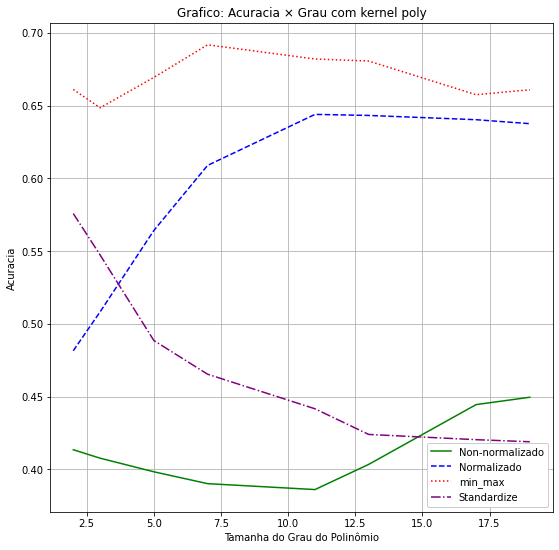

In [227]:
#Plot 
#plt.plot(acuracias_poly[:,0], acuracias_poly[:,1], color='g', label='acc')
plt.plot(acuracias_poly.iloc[:,0].values, [x.mean() for x in acuracias_poly.iloc[:,1].to_numpy()], color='g', label='Non-normalizado')
plt.plot(acuracias_norm_poly.iloc[:,0].values, [x.mean() for x in acuracias_norm_poly.iloc[:,1].to_numpy()], color='b' , linestyle='--', label='Normalizado')
plt.plot(acuracias_mm_poly.iloc[:,0].values, [x.mean() for x in acuracias_mm_poly.iloc[:,1].to_numpy()], color='r',linestyle=':', label='min_max')
plt.plot(acuracias_stand_poly.iloc[:,0].values, [x.mean() for x in acuracias_stand_poly.iloc[:,1].to_numpy()], color='purple',linestyle='-.', label='Standardize')

plt.ylabel('Acuracia')
plt.xlabel('Tamanha do Grau do Polinômio')
plt.title('Grafico: Acuracia × Grau com kernel poly')
plt.legend(framealpha=1, frameon=True)
plt.grid(True)
plt.show()

In [228]:
#Treimando non-preprocessing
acuracias_linear = pd.DataFrame(valida_paremetros(C,X_train,y_train,kernel_='linear',axis_=1), columns=['C', 'Acuracias'])
print(acuracias_linear)

      C                                          Acuracias
0     2  [0.5930252100840336, 0.5673109243697478, 0.599...
1     3  [0.5959663865546219, 0.5789915966386554, 0.611...
2     5  [0.6019327731092436, 0.5965546218487395, 0.611...
3     7  [0.6077310924369748, 0.6025210084033613, 0.599...
4    11  [0.6164705882352941, 0.6053781512605042, 0.605...
5    13  [0.6165546218487395, 0.602436974789916, 0.6084...
6    17  [0.6019327731092436, 0.6084033613445378, 0.602...
7    19  [0.6047899159663865, 0.6025210084033613, 0.602...
8    23  [0.5989075630252101, 0.5995798319327731, 0.602...
9    29  [0.5959663865546219, 0.5966386554621849, 0.599...
10   31  [0.5959663865546219, 0.5966386554621849, 0.599...
11   37  [0.5988235294117648, 0.5994957983193278, 0.602...
12   41  [0.5988235294117648, 0.602436974789916, 0.5997...
13   43  [0.6046218487394958, 0.602436974789916, 0.5938...
14   47  [0.6105042016806723, 0.6083193277310924, 0.599...
15   53  [0.607563025210084, 0.6112605042016807, 0.6055.

In [229]:
acuracias_mm_linear = pd.DataFrame(valida_paremetros(C,X_min_max_train.values,y_min_max_train,kernel_='linear',axis_=1), columns=['C', 'Acuracias'])
print(acuracias_mm_linear)

      C                                          Acuracias
0     2  [0.5529556650246306, 0.5950738916256156, 0.570...
1     3  [0.5842364532019704, 0.5986453201970443, 0.591...
2     5  [0.5950738916256159, 0.6092364532019705, 0.616...
3     7  [0.6019704433497537, 0.6302955665024632, 0.640...
4    11  [0.6123152709359606, 0.644334975369458, 0.6259...
5    13  [0.6158866995073892, 0.6373152709359606, 0.633...
6    17  [0.6055418719211823, 0.6373152709359606, 0.629...
7    19  [0.6019704433497537, 0.6336206896551724, 0.629...
8    23  [0.5915024630541872, 0.6509852216748768, 0.626...
9    29  [0.5913793103448275, 0.6544334975369458, 0.622...
10   31  [0.5915024630541872, 0.6544334975369458, 0.629...
11   37  [0.5985221674876847, 0.6545566502463054, 0.626...
12   41  [0.5986453201970442, 0.6511083743842364, 0.622...
13   43  [0.5950738916256157, 0.6649014778325124, 0.622...
14   47  [0.6019704433497537, 0.6614532019704433, 0.622...
15   53  [0.601847290640394, 0.6649014778325124, 0.6261.

In [230]:
acuracias_norm_linear = pd.DataFrame(valida_paremetros(C,X_norm_train.values,y_norm_train,kernel_='linear',axis_=1), columns=['C', 'Acuracias'])
print(acuracias_norm_linear)

      C                                          Acuracias
0     2  [0.30825123152709366, 0.31477832512315274, 0.3...
1     3  [0.30825123152709366, 0.31477832512315274, 0.3...
2     5  [0.30825123152709366, 0.31477832512315274, 0.3...
3     7  [0.30825123152709366, 0.31477832512315274, 0.3...
4    11  [0.30825123152709366, 0.31477832512315274, 0.3...
5    13  [0.30825123152709366, 0.31477832512315274, 0.3...
6    17  [0.30825123152709366, 0.31477832512315274, 0.3...
7    19  [0.29396551724137937, 0.31477832512315274, 0.3...
8    23  [0.29396551724137937, 0.31822660098522165, 0.3...
9    29  [0.3045566502463054, 0.31822660098522165, 0.31...
10   31  [0.3151477832512316, 0.3320197044334975, 0.321...
11   37  [0.33633004926108373, 0.35665024630541875, 0.3...
12   41  [0.3571428571428571, 0.3951970443349754, 0.359...
13   43  [0.3571428571428571, 0.4023399014778325, 0.366...
14   47  [0.367487684729064, 0.40258620689655167, 0.380...
15   53  [0.39507389162561574, 0.41982758620689653, 0.3.

In [231]:
acuracias_stand_linear = pd.DataFrame(valida_paremetros(C,X_stand_train.values,y_stand_train,kernel_='linear',axis_=1), columns=['C', 'Acuracias'])
print(acuracias_stand_linear)

      C                                          Acuracias
0     2  [0.636576354679803, 0.671551724137931, 0.63965...
1     3  [0.6541871921182267, 0.6713054187192118, 0.639...
2     5  [0.6432266009852217, 0.6748768472906403, 0.639...
3     7  [0.6327586206896553, 0.6576354679802956, 0.632...
4    11  [0.6293103448275862, 0.6469211822660099, 0.635...
5    13  [0.6189655172413793, 0.6573891625615763, 0.635...
6    17  [0.6258620689655172, 0.6469211822660099, 0.632...
7    19  [0.6257389162561575, 0.6435960591133005, 0.629...
8    23  [0.6326354679802955, 0.6401477832512315, 0.632...
9    29  [0.6293103448275862, 0.6401477832512315, 0.625...
10   31  [0.6293103448275862, 0.6366995073891626, 0.632...
11   37  [0.6222906403940885, 0.6402709359605911, 0.632...
12   41  [0.6222906403940885, 0.6402709359605911, 0.628...
13   43  [0.6188423645320197, 0.6402709359605911, 0.632...
14   47  [0.6188423645320197, 0.64371921182266, 0.62894...
15   53  [0.6222906403940887, 0.647167487684729, 0.6323.

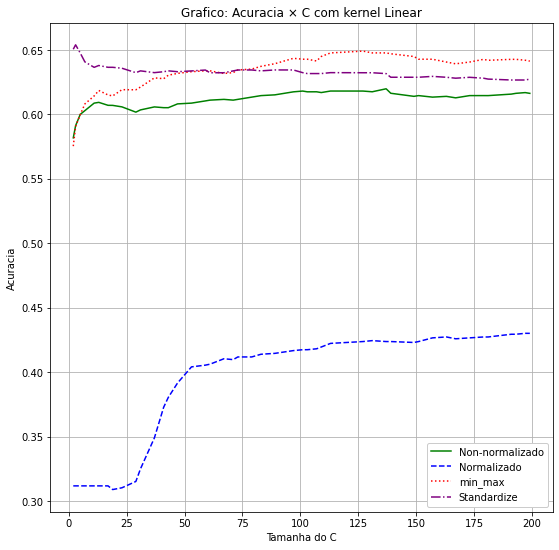

In [232]:
#Plot 
plt.plot(acuracias_linear.iloc[:,0].values, [x.mean() for x in acuracias_linear.iloc[:,1].to_numpy()], color='g', label='Non-normalizado')
plt.plot(acuracias_norm_linear.iloc[:,0].values, [x.mean() for x in acuracias_norm_linear.iloc[:,1].to_numpy()], color='b' , linestyle='--', label='Normalizado')
plt.plot(acuracias_mm_linear.iloc[:,0].values, [x.mean() for x in acuracias_mm_linear.iloc[:,1].to_numpy()], color='r',linestyle=':', label='min_max')

plt.plot(acuracias_stand_linear.iloc[:,0].values, [x.mean() for x in acuracias_stand_linear.iloc[:,1].to_numpy()], color='purple',linestyle='-.', label='Standardize')
plt.ylabel('Acuracia')
plt.xlabel('Tamanha do C')
plt.title('Grafico: Acuracia × C com kernel Linear')
plt.grid(True)
plt.legend(framealpha=1, frameon=True)
plt.show()

In [233]:
acuracias_sigmoid = pd.DataFrame(valida_paremetros(C,X_train,y_train,kernel_='sigmoid',axis_=1), columns=['C', 'Acuracias'])
print(acuracias_sigmoid)

      C                                          Acuracias
0     2  [0.33613445378151263, 0.32731092436974796, 0.3...
1     3  [0.33613445378151263, 0.32731092436974796, 0.3...
2     5  [0.33613445378151263, 0.32731092436974796, 0.3...
3     7  [0.33613445378151263, 0.32731092436974796, 0.3...
4    11  [0.33613445378151263, 0.32731092436974796, 0.3...
5    13  [0.33613445378151263, 0.32731092436974796, 0.3...
6    17  [0.33613445378151263, 0.32731092436974796, 0.3...
7    19  [0.33613445378151263, 0.32731092436974796, 0.3...
8    23  [0.33613445378151263, 0.32731092436974796, 0.3...
9    29  [0.33613445378151263, 0.32731092436974796, 0.3...
10   31  [0.33613445378151263, 0.32731092436974796, 0.3...
11   37  [0.33613445378151263, 0.32731092436974796, 0.3...
12   41  [0.33613445378151263, 0.32731092436974796, 0.3...
13   43  [0.33613445378151263, 0.32731092436974796, 0.3...
14   47  [0.33613445378151263, 0.32731092436974796, 0.3...
15   53  [0.33613445378151263, 0.32731092436974796, 0.3.

In [234]:
acuracias_mm_sigmoid = pd.DataFrame(valida_paremetros(C,X_min_max_train.values,y_min_max_train,kernel_='sigmoid',axis_=1), columns=['C', 'Acuracias'])
print(acuracias_mm_sigmoid)

      C                                          Acuracias
0     2  [0.4268472906403941, 0.47573891625615766, 0.43...
1     3  [0.4268472906403941, 0.46182266009852224, 0.42...
2     5  [0.42007389162561576, 0.4098522167487685, 0.41...
3     7  [0.40591133004926105, 0.45800492610837445, 0.3...
4    11  [0.40615763546798034, 0.4264778325123153, 0.40...
5    13  [0.4097290640394089, 0.43349753694581283, 0.43...
6    17  [0.41342364532019704, 0.42660098522167483, 0.4...
7    19  [0.4098522167487685, 0.43349753694581283, 0.42...
8    23  [0.4062807881773399, 0.4266009852216749, 0.410...
9    29  [0.4062807881773399, 0.4336206896551724, 0.406...
10   31  [0.4097290640394089, 0.43004926108374386, 0.42...
11   37  [0.4097290640394089, 0.4302955665024631, 0.427...
12   41  [0.41317733990147787, 0.43386699507389165, 0.4...
13   43  [0.41317733990147787, 0.43731527093596056, 0.4...
14   47  [0.4061576354679802, 0.4443349753694581, 0.420...
15   53  [0.4096059113300492, 0.4336206896551724, 0.417.

In [235]:
acuracias_norm_sigmoid = pd.DataFrame(valida_paremetros(C,X_norm_train.values,y_norm_train,kernel_='sigmoid',axis_=1), columns=['C', 'Acuracias'])
print(acuracias_norm_sigmoid)

      C                                          Acuracias
0     2  [0.30825123152709366, 0.31477832512315274, 0.3...
1     3  [0.30825123152709366, 0.31477832512315274, 0.3...
2     5  [0.30825123152709366, 0.31477832512315274, 0.3...
3     7  [0.30825123152709366, 0.31477832512315274, 0.3...
4    11  [0.30825123152709366, 0.31477832512315274, 0.3...
5    13  [0.30825123152709366, 0.31477832512315274, 0.3...
6    17  [0.30825123152709366, 0.31477832512315274, 0.3...
7    19  [0.30825123152709366, 0.31477832512315274, 0.3...
8    23  [0.30825123152709366, 0.31477832512315274, 0.3...
9    29  [0.30825123152709366, 0.31477832512315274, 0.3...
10   31  [0.30825123152709366, 0.31477832512315274, 0.3...
11   37  [0.30825123152709366, 0.31477832512315274, 0.3...
12   41  [0.30825123152709366, 0.31477832512315274, 0.3...
13   43  [0.30825123152709366, 0.31477832512315274, 0.3...
14   47  [0.30825123152709366, 0.31477832512315274, 0.3...
15   53  [0.30825123152709366, 0.31477832512315274, 0.3.

In [236]:
acuracias_stand_sigmoid = pd.DataFrame(valida_paremetros(C,X_stand_train.values,y_stand_train,kernel_='sigmoid',axis_=1), columns=['C', 'Acuracias'])
print(acuracias_stand_sigmoid)

      C                                          Acuracias
0     2  [0.5283251231527093, 0.5392857142857143, 0.514...
1     3  [0.5110837438423645, 0.5529556650246304, 0.521...
2     5  [0.5112068965517241, 0.5141625615763546, 0.496...
3     7  [0.49716748768472907, 0.5178571428571428, 0.47...
4    11  [0.48977832512315267, 0.5002463054187192, 0.45...
5    13  [0.483128078817734, 0.48977832512315267, 0.440...
6    17  [0.4550492610837439, 0.49642857142857133, 0.45...
7    19  [0.46194581280788183, 0.4858374384236453, 0.45...
8    23  [0.44790640394088677, 0.4752463054187192, 0.44...
9    29  [0.4513546798029557, 0.48903940886699504, 0.45...
10   31  [0.44790640394088677, 0.4752463054187192, 0.45...
11   37  [0.4583743842364532, 0.4820197044334975, 0.465...
12   41  [0.47586206896551725, 0.47857142857142854, 0.4...
13   43  [0.4722906403940887, 0.4817733990147783, 0.433...
14   47  [0.4619458128078818, 0.47155172413793106, 0.43...
15   53  [0.46551724137931033, 0.475, 0.426600985221674.

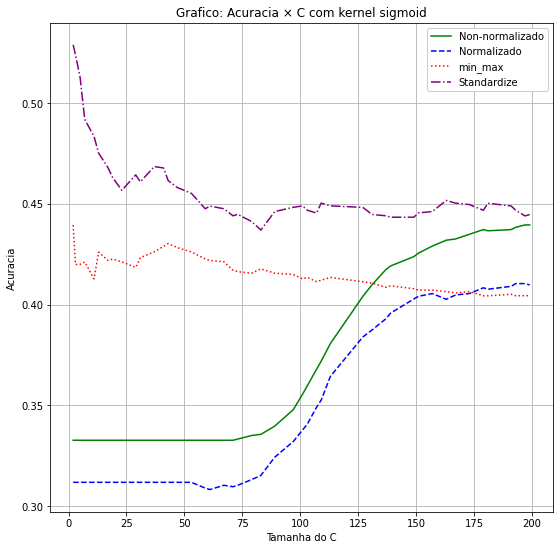

In [237]:
#Plot 
plt.plot(acuracias_sigmoid.iloc[:,0].values, [x.mean() for x in acuracias_sigmoid.iloc[:,1].to_numpy()], color='g', label='Non-normalizado')
plt.plot(acuracias_norm_sigmoid.iloc[:,0].values, [x.mean() for x in acuracias_norm_sigmoid.iloc[:,1].to_numpy()], color='b' , linestyle='--', label='Normalizado')
plt.plot(acuracias_mm_sigmoid.iloc[:,0].values, [x.mean() for x in acuracias_mm_sigmoid.iloc[:,1].to_numpy()], color='r',linestyle=':', label='min_max')

plt.plot(acuracias_stand_sigmoid.iloc[:,0].values, [x.mean() for x in acuracias_stand_sigmoid.iloc[:,1].to_numpy()], color='purple',linestyle='-.', label='Standardize')
plt.ylabel('Acuracia')
plt.xlabel('Tamanha do C')
plt.title('Grafico: Acuracia × C com kernel sigmoid')
plt.grid(True)
plt.legend(framealpha=1, frameon=True)
plt.show()

In [238]:
#Colocar um texto explicando 

In [239]:
#RBF
C_max_non_norm = acuracias.iloc[np.argmax(np.array([x.mean() for x in acuracias.iloc[:,1].to_numpy()])),0]
C_max_min_max = acuracias_mm.iloc[np.argmax(np.array([x.mean() for x in acuracias_mm.iloc[:,1].to_numpy()])),0]
C_max_norm = acuracias_norm.iloc[np.argmax(np.array([x.mean() for x in acuracias_norm.iloc[:,1].to_numpy()])),0]
C_max_stand = acuracias_stand.iloc[np.argmax(np.array([x.mean() for x in acuracias_stand.iloc[:,1].to_numpy()])),0]

#Grau poly
d_max_non_norm = acuracias_poly.iloc[np.argmax(np.array([x.mean() for x in acuracias_poly.iloc[:,1].to_numpy()])),0]
d_max_min_max = acuracias_mm_poly.iloc[np.argmax(np.array([x.mean() for x in acuracias_mm_poly.iloc[:,1].to_numpy()])),0]
d_max_norm = acuracias_norm_poly.iloc[np.argmax(np.array([x.mean() for x in acuracias_norm_poly.iloc[:,1].to_numpy()])),0]
d_max_stand = acuracias_stand_poly.iloc[np.argmax(np.array([x.mean() for x in acuracias_stand_poly.iloc[:,1].to_numpy()])),0]

#Linear
C_max_non_norm_linear = acuracias_linear.iloc[np.argmax(np.array([x.mean() for x in acuracias_linear.iloc[:,1].to_numpy()])),0]
C_max_min_max_linear = acuracias_mm_linear.iloc[np.argmax(np.array([x.mean() for x in acuracias_mm_linear.iloc[:,1].to_numpy()])),0]
C_max_norm_linear = acuracias_norm_linear.iloc[np.argmax(np.array([x.mean() for x in acuracias_norm_linear.iloc[:,1].to_numpy()])),0]
C_max_stand_linear = acuracias_stand_linear.iloc[np.argmax(np.array([x.mean() for x in acuracias_stand_linear.iloc[:,1].to_numpy()])),0]

#Sigmoid
C_max_non_norm_sigmoid = acuracias_sigmoid.iloc[np.argmax(np.array([x.mean() for x in acuracias_sigmoid.iloc[:,1].to_numpy()])),0]
C_max_min_max_sigmoid = acuracias_mm_sigmoid.iloc[np.argmax(np.array([x.mean() for x in acuracias_mm_sigmoid.iloc[:,1].to_numpy()])),0]
C_max_norm_sigmoid = acuracias_norm_sigmoid.iloc[np.argmax(np.array([x.mean() for x in acuracias_norm_sigmoid.iloc[:,1].to_numpy()])),0]
C_max_stand_sigmoid = acuracias_stand_sigmoid.iloc[np.argmax(np.array([x.mean() for x in acuracias_stand_sigmoid.iloc[:,1].to_numpy()])),0]

print('Parametros Separados')

Parametros Separados


In [240]:
#classificador para base não processada
clf_rbf_non = svm.SVC(C=C_max_non_norm)
clf_poly_non = svm.SVC(C=C_max_non_norm,degree=d_max_non_norm)
clf_linear_non = svm.SVC(C=C_max_non_norm_linear)
clf_sig_non = svm.SVC(C=C_max_non_norm_sigmoid)

#classificador para base normalizada
clf_rbf_norm = svm.SVC(C=C_max_norm)
clf_poly_norm = svm.SVC(C=C_max_norm,degree=d_max_min_max)
clf_linear_norm = svm.SVC(C=C_max_min_max_linear)
clf_sig_norm = svm.SVC(C=C_max_stand_sigmoid)

#classificador para base Min_max
clf_rbf_mm = svm.SVC(C=C_max_min_max)
clf_poly_mm = svm.SVC(C=C_max_min_max,degree=d_max_stand)
clf_linear_mm = svm.SVC(C=C_max_norm_linear)
clf_sig_mm = svm.SVC(C=C_max_norm_sigmoid)

#classificador para base stand
clf_rbf_stand = svm.SVC(C=C_max_stand)
clf_poly_stand = svm.SVC(C=C_max_stand,degree=d_max_stand)
clf_linear_stand = svm.SVC(C=C_max_stand_linear)
clf_sig_stand = svm.SVC(C=C_max_stand_sigmoid)


print('Inicalizacao dos classificadores com os paremetros validados')

Inicalizacao dos classificadores com os paremetros validados


In [241]:
#ajuste para base non
clf_rbf_non.fit(X_train, y_train)
clf_poly_non.fit(X_train, y_train)
clf_linear_non.fit(X_train, y_train)
clf_sig_non.fit(X_train, y_train)

clf_rbf_norm.fit(X_norm_train,y_norm_train)
clf_poly_norm.fit(X_norm_train,y_norm_train)
clf_linear_norm.fit(X_norm_train,y_norm_train)
clf_sig_norm.fit(X_norm_train,y_norm_train)

#classificador p
clf_rbf_mm.fit(X_min_max_train,y_min_max_train)
clf_poly_mm.fit(X_min_max_train,y_min_max_train)
clf_linear_mm.fit(X_min_max_train,y_min_max_train)
clf_sig_mm.fit(X_min_max_train,y_min_max_train)

#classificador p
clf_rbf_stand.fit(X_stand_train,y_stand_train)
clf_poly_stand.fit(X_stand_train,y_stand_train)
clf_linear_stand.fit(X_stand_train,y_stand_train)
clf_sig_stand.fit(X_stand_train,y_stand_train)
print('Modelos treinados')

Modelos treinados


In [242]:
y_non_svm_rbf = clf_rbf_non.predict(X_test)
y_non_svm_poly = clf_poly_non.predict(X_test)
y_non_svm_lin = clf_linear_non.predict(X_test)
y_non_svm_sig = clf_sig_non.predict(X_test)

y_norm_svm_rbf =clf_rbf_norm.predict(X_norm_test)
y_norm_svm_poly = clf_poly_norm.predict(X_norm_test)
y_norm_svm_lin = clf_linear_norm.predict(X_norm_test)
y_norm_svm_sig = clf_sig_norm.predict(X_norm_test)

y_mm_svm_rbf = clf_rbf_mm.predict(X_min_max_test)
y_mm_svm_poly = clf_poly_mm.predict(X_min_max_test)
y_mm_svm_lin = clf_linear_mm.predict(X_min_max_test)
y_mm_svm_sig = clf_sig_mm.predict(X_min_max_test)

y_stand_svm_rbf =  clf_rbf_stand.predict(X_stand_test)
y_stand_svm_poly = clf_poly_stand.predict(X_stand_test)
y_stand_svm_lin = clf_linear_stand.predict(X_stand_test)
y_stand_svm_sig = clf_sig_stand.predict(X_stand_test)

print('predicao')

predicao


In [243]:
y_knn_non = knn.fit(X_train, y_train).predict(X_test)
y_reg_non = reg.fit(X_train, y_train).predict(X_test)
y_gnb_non = gnb.fit(X_train, y_train).predict(X_test)

y_knn_norm = knn.fit(X_norm_train, y_norm_train).predict(X_norm_test)
y_reg_norm = reg.fit(X_norm_train, y_norm_train).predict(X_norm_test)
y_gnb_norm = gnb.fit(X_norm_train, y_norm_train).predict(X_norm_test)

y_knn_mm = knn.fit(X_min_max_train, y_min_max_train).predict(X_min_max_test)
y_reg_mm = reg.fit(X_min_max_train, y_min_max_train).predict(X_min_max_test)
y_gnb_mm = gnb.fit(X_min_max_train, y_min_max_train).predict(X_min_max_test)

y_knn_stand = knn.fit(X_stand_train, y_stand_train).predict(X_stand_test)
y_reg_stand = reg.fit(X_stand_train, y_stand_train).predict(X_stand_test)
y_gnd_stand = gnb.fit(X_stand_train, y_stand_train).predict(X_stand_test)


In [244]:
metricas_non = [accuracy_score(y_test, y_knn_non), accuracy_score(y_test, y_gnb_non), accuracy_score(y_test, y_reg_non), accuracy_score(y_test, y_non_svm_rbf), accuracy_score(y_test, y_non_svm_poly),  accuracy_score(y_test, y_non_svm_lin), accuracy_score(y_test, y_non_svm_sig)]

metricas_norm = [accuracy_score(y_norm_test, y_knn_norm), accuracy_score(y_norm_test, y_gnb_norm), accuracy_score(y_norm_test, y_reg_norm), accuracy_score(y_norm_test, y_norm_svm_rbf), accuracy_score(y_norm_test, y_norm_svm_poly),  accuracy_score(y_norm_test, y_norm_svm_lin), accuracy_score(y_norm_test, y_norm_svm_sig)]

metricas_mm = [accuracy_score(y_min_max_test, y_knn_mm), accuracy_score(y_min_max_test, y_reg_mm), accuracy_score(y_min_max_test, y_reg_mm), accuracy_score(y_min_max_test, y_mm_svm_rbf), accuracy_score(y_min_max_test, y_mm_svm_poly),  accuracy_score(y_min_max_test, y_mm_svm_lin), accuracy_score(y_min_max_test, y_mm_svm_sig)]

metricas_stand = [accuracy_score(y_stand_test, y_knn_stand), accuracy_score(y_stand_test, y_gnd_stand), accuracy_score(y_stand_test, y_reg_stand), accuracy_score(y_stand_test, y_stand_svm_rbf), accuracy_score(y_stand_test, y_stand_svm_poly),  accuracy_score(y_stand_test, y_stand_svm_lin), accuracy_score(y_stand_test, y_stand_svm_sig)]

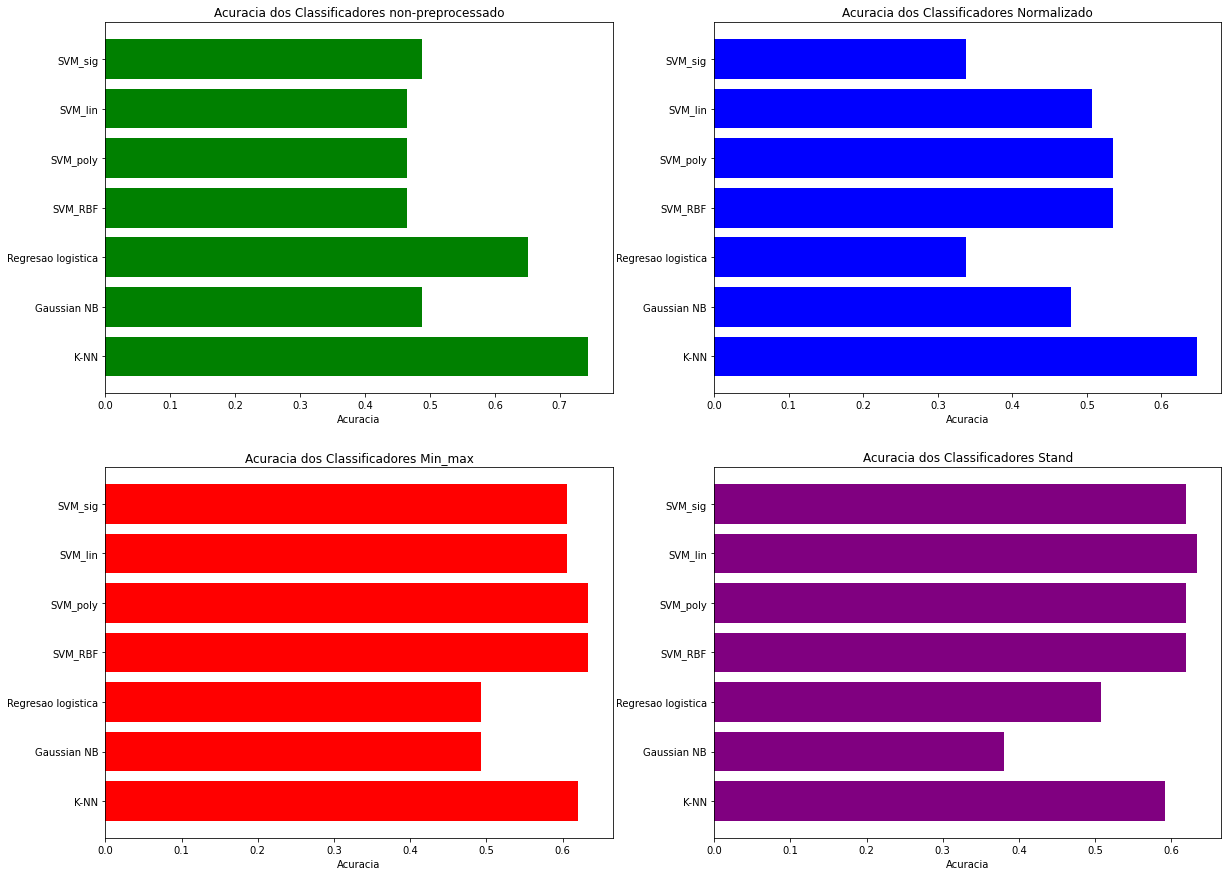

In [247]:
## Grafico de acuracia
nome_classificadores = ['K-NN', 'Gaussian NB', 'Regresao logistica','SVM_RBF', 'SVM_poly', 'SVM_lin', 'SVM_sig']

fig, axs = plt.subplots(2,2)
plt.rcParams["figure.figsize"] = (25,15)
axs[0][0].set_title('Acuracia dos Classificadores non-preprocessado')
axs[0][0].barh(nome_classificadores, metricas_non, color='g')
axs[0][0].set_xlabel('Acuracia')

axs[0][1].set_title('Acuracia dos Classificadores Normalizado')
axs[0][1].barh(nome_classificadores, metricas_norm, color='b')
axs[0][1].set_xlabel('Acuracia')

axs[1][0].set_title('Acuracia dos Classificadores Min_max')
axs[1][0].barh(nome_classificadores, metricas_mm, color='r')
axs[1][0].set_xlabel('Acuracia')

axs[1][1].set_title('Acuracia dos Classificadores Stand')
axs[1][1].barh(nome_classificadores, metricas_stand, color='purple')
axs[1][1].set_xlabel('Acuracia')


plt.show()

#Referencias

1. Um guia completo para o pré-processamento de dados em machine learning -  https://caiquecoelho.medium.com/um-guia-completo-para-o-pr%C3%A9-processamento-de-dados-em-machine-learning-f860fbadabe1 
1. Magnitude e normalização de vetores - https://pt.khanacademy.org/computing/computer-programming/programming-natural-simulations/programming-vectors/a/vector-magnitude-normalization#:~:text=Em%20outras%20palavras%2C%20para%20normalizar,5%20sobre%205%20%C3%A9%201.